In [4]:
import sys
sys.path.append('..')
import alfw
from alfw import Face, lmnames, goodmarksnames, split
import numpy as np
import matplotlib.pyplot as plt
import skimage
%matplotlib inline

from keras.initializations import *
from keras.models import Model
from keras.layers import Dropout, Activation, Flatten, Dense, Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Merge, Reshape, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.objectives import mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ProgbarLogger, EarlyStopping
from keras import backend as K
import keras
from theano.sandbox.cuda.dnn import *
import sklearn.metrics
import scipy

In [5]:
Xtrain, ytrain, ht, mm, Xtest, ytest, hts, mmt, (mean, std, meany, stdy, meani, stdi), scale, unscale, d = alfw.prepare(200000, onlyvisible=True)
print 'ytrain ', ytrain.shape    
print Xtrain.shape

print 'mean ', np.mean(Xtrain, axis=3).shape

# to grey
Xtrain = np.mean(Xtrain, axis=3).reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)
Xtest = np.mean(Xtest, axis=3).reshape(Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], 1)
Xtest1 = Xtest

# normalize between 0 , 1
Xtrain, ytrain, ht = scale( Xtrain, ytrain, ht )
Xtest, ytest, hts = scale( Xtest, ytest, hts )

loading..
im.shape:  (21776, 128, 128, 3)
feats.shape: (21776, 28, 2)
hogs.shape: (21776, 8100)
goodmarks  (12, 21776, 2)
8166 21776
ytrain.shape  (7349, 12, 2)
ytrain  (7349, 12, 2)
(7349, 128, 128, 3)
mean  (7349, 128, 128)


## classification gender

play with data augmentation
cnn structure (maxpooling, conv layers)



In [6]:
genders = np.asarray([x.genre == 'f' for x in d['md'][0]])
genders_test = np.asarray([x.genre == 'f' for x in d['md'][1]])
print genders[20:]*1
print genders.shape

[1 1 0 ..., 1 1 0]
(7349,)


In [8]:
# simple mlp
# input is 2D grey scale
inputs = Input((1, alfw.size, alfw.size))
conv01 = Convolution2D(32, 5, 5, subsample=(2,2), activation='relu')(inputs)
conv2 = Convolution2D(32, 3, 3, activation='relu')(conv01)
mp1 = MaxPooling2D((2,2))(conv2)
conv2 = Convolution2D(64, 3,3, activation='relu')(mp1)
conv3 = Convolution2D(64, 3,3, activation='relu')(conv2)
mp2 = MaxPooling2D((2,2))(conv3)
f = Flatten()(mp2)
h2 = Dense(16)(f)
h1 = Dense(1, activation='sigmoid')(h2)
modelGender = Model(input=inputs, output=h1)
sgd = SGD(lr=0.0051, momentum=0.9, nesterov=True, decay=1e-6)
modelGender.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
modelGender.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 128, 128)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 62, 62)    832         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 60, 60)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 30, 30)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## Augmenting the data

In [9]:
print Xtrain.shape
XtrainM = Xtrain[:,:,::-1,:]
print XtrainM.shape

XtrainA = np.concatenate((Xtrain, XtrainM), axis=0)
gendersA = np.concatenate((genders, genders), axis=0)

(7349, 128, 128, 1)
(7349, 128, 128, 1)


In [10]:
history = modelGender.fit(np.transpose(XtrainA, (0, 3, 1, 2)),
                    (gendersA*1).astype(np.float32),
                    batch_size=128,
                    nb_epoch=10, verbose=1, shuffle=True,
                    validation_split = 0.3)

Train on 10288 samples, validate on 4410 samples
Epoch 1/10
10288/10288 [==============================] - 9s - loss: 0.6731 - acc: 0.5647 - val_loss: 0.5949 - val_acc: 0.6887
Epoch 2/10
10288/10288 [==============================] - 9s - loss: 0.6118 - acc: 0.6652 - val_loss: 0.5724 - val_acc: 0.7156
Epoch 3/10
10288/10288 [==============================] - 9s - loss: 0.5823 - acc: 0.6964 - val_loss: 0.5486 - val_acc: 0.7120
Epoch 4/10
10288/10288 [==============================] - 9s - loss: 0.5399 - acc: 0.7240 - val_loss: 0.5120 - val_acc: 0.7454
Epoch 5/10
10288/10288 [==============================] - 9s - loss: 0.5038 - acc: 0.7523 - val_loss: 0.4785 - val_acc: 0.7719
Epoch 6/10
10288/10288 [==============================] - 9s - loss: 0.4776 - acc: 0.7695 - val_loss: 0.4648 - val_acc: 0.7753
Epoch 7/10
10288/10288 [==============================] - 9s - loss: 0.4566 - acc: 0.7806 - val_loss: 0.4700 - val_acc: 0.7819
Epoch 8/10
10288/10288 [==============================] - 9s -

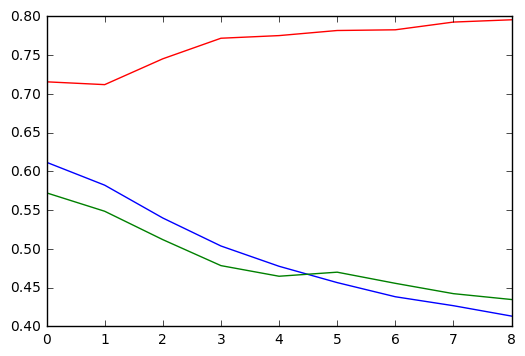

In [11]:
history.history
plt.plot(history.history['loss'][1:], color='blue', label='train')
plt.plot(history.history['val_loss'][1:], color='green' )
plt.plot(history.history['val_acc'][1:], color='red' )


(array([ 365.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  452.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

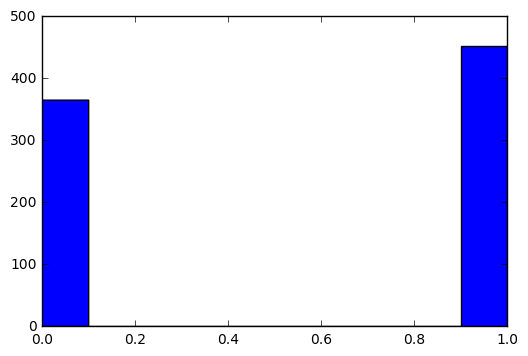

In [12]:
plt.hist(genders_test*1)

(817,)
accuracy 0.882500909201
0.795593635251


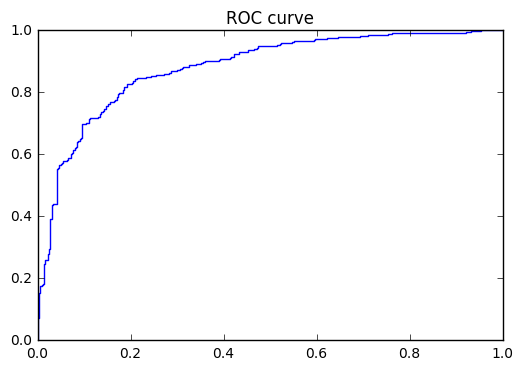

In [13]:
predtest = modelGender.predict(np.transpose(Xtest, (0, 3, 1, 2)))[:,0]
print predtest.shape
print 'accuracy',  sklearn.metrics.roc_auc_score(genders_test * 1 , predtest)
print sklearn.metrics.accuracy_score(genders_test * 1 , predtest>0.5)
fp, tp, _ = sklearn.metrics.roc_curve(genders_test * 1 , predtest)
plt.title('ROC curve')
plt.plot(fp, tp)



In [14]:
print Xtest.shape
modelGender.predict(np.transpose(Xtest[31:32,:,:,:], (0, 3, 1, 2)))
print genders_test[31]*1

(817, 128, 128, 1)
0


(1, 1, 128, 128)

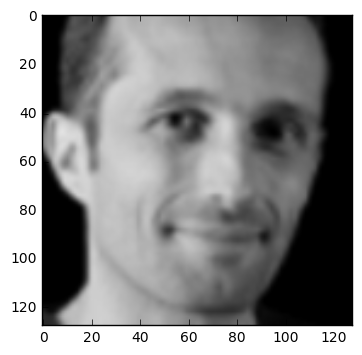

In [15]:
fn = '../data/cg.PNG'
fn = '../data/pp.png'

pp = scipy.misc.imread(fn)
pp = pp[:,:,0:3]
pp = scipy.misc.imresize(pp, (128,128))
plt.imshow(pp[:,:,0:3])
pp = np.mean(pp, axis=2, keepdims=True)

np.transpose([pp], (0, 3, 1, 2)).shape

## clearly indeed a male

In [17]:
'this a ' + {0 : "man", 1 : "woman"}[int(modelGender.predict(np.transpose([pp], (0, 3, 1, 2)))>0.5)]

'this a man'